In [1]:
%load_ext autoreload
%autoreload 2

import os

import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import scipy.optimize

import ultraplot as uplt

In [2]:
from des_y6_imsim_analysis import bump
from des_y6_imsim_analysis.stats import compute_model_chi2_info, measure_map, run_mcmc
from des_y6_imsim_analysis.utils import (
    compute_eff_nz_from_data,
    compute_nz_binned_mean,
    nz_binned_to_interp,
    read_data,
)


In [3]:
import hashlib

import tqdm
import yaml

fit_stats = {}
fit_data = {}

all_num_bins = [9, 10]
all_w = [0.1, 0.2]
fnames = [
    "../../data/N_gamma_alpha_v2_statistical.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-occupancy.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-neighbor.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-neighbor-occupancy.hdf5",
]
keys = [
    os.path.basename(fname).replace(".hdf5", "").split("_")[-1]
    for fname in fnames
]

with tqdm.tqdm(ncols=80, total=len(all_num_bins) * len(all_w) * len(keys), desc="fitting models") as pbar:
    for num_bins in all_num_bins:
        fit_data[num_bins] = {}
        fit_stats[num_bins] = {}

        for w in all_w:
            fit_data[num_bins][w] = {}
            fit_stats[num_bins][w] = {}

            # these seeds are the ones used in the original analysis.
            # seeds = [213432, 6457645, 213, 7878546]
            # for keys statistical, statistical-occupancy, statistical-neighbor, statistical-neighbor-occupancy
            # now using hash to make deterministic, but different seeds
            seeds = [
                (
                    abs(
                        int(
                            hashlib.sha256((key + str(num_bins) + str(w)).encode("utf-8")).hexdigest(),
                            16,
                        )
                    )
                    + 1
                ) % 2**32
                for key in keys
            ]

            model_module = bump

            for key, fname, seed in zip(keys, fnames, seeds):
                data = read_data(fname)

                model_data = model_module.make_model_data(
                    z=data.z,
                    nzs=data.nzs,
                    mn=data.mn,
                    cov=data.cov,
                    mn_pars=data.mn_pars,
                    zbins=data.zbins,
                    fixed_param_values={"w": w, "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0},
                    num_bins=num_bins,
                )

                map_params = measure_map(
                    model_module=model_module,
                    model_data=model_data,
                    seed=seed,
                )

                mcmc = run_mcmc(
                    model_module=model_module,
                    model_data=model_data,
                    init_params=map_params,
                    seed=seed,
                )

                chi2_info = compute_model_chi2_info(
                    model_module=model_module,
                    model_data=model_data,
                    data=data,
                    params=map_params,
                )

                fit_data[num_bins][w][key] = {
                    "map_params": map_params,
                    "mcmc": mcmc,
                    "model_data": model_data,
                    "data": data,
                    "seed": seed,
                }

                fit_stats[num_bins][w][key] = {
                    "key": key,
                    "num_bins": num_bins,
                    "w": w,
                    "chi2": float(chi2_info['chi2']),
                    "dof": int(chi2_info['dof']),
                    "p_value": float(chi2_info['p_value']),
                    "seed": seed,
                }
                pbar.write(
                    yaml.dump(
                        fit_stats[num_bins][w][key],
                        default_flow_style=False,
                        indent=2,
                    )
                )
                fit_stats[num_bins][w][key]["map_params"] = {k: float(v) for k, v in map_params.items()}

                pbar.update(1)


fitting models:   6%|█▊                          | 1/16 [00:51<12:45, 51.03s/it]

chi2: 3.832692093665237
dof: 8
key: statistical
num_bins: 9
p_value: 0.8718941730679164
seed: 2215892852
w: 0.1



fitting models:  12%|███▌                        | 2/16 [01:40<11:39, 49.94s/it]

chi2: 4.0162403846944335
dof: 8
key: statistical-occupancy
num_bins: 9
p_value: 0.8556552292918473
seed: 371142736
w: 0.1



fitting models:  19%|█████▎                      | 3/16 [02:31<10:59, 50.71s/it]

chi2: 5.9844395315332335
dof: 8
key: statistical-neighbor
num_bins: 9
p_value: 0.6489749806544172
seed: 1016334285
w: 0.1



fitting models:  25%|███████                     | 4/16 [03:24<10:15, 51.30s/it]

chi2: 5.4240163141488305
dof: 8
key: statistical-neighbor-occupancy
num_bins: 9
p_value: 0.7114430242551991
seed: 2043537833
w: 0.1



fitting models:  31%|████████▍                  | 5/16 [06:35<18:40, 101.86s/it]

chi2: 5.869912731201935
dof: 8
key: statistical
num_bins: 9
p_value: 0.6618009202496864
seed: 1311528224
w: 0.2



fitting models:  38%|██████████▏                | 6/16 [09:54<22:28, 134.82s/it]

chi2: 4.559215688377208
dof: 8
key: statistical-occupancy
num_bins: 9
p_value: 0.8034799425191702
seed: 2042521859
w: 0.2



fitting models:  44%|███████████▊               | 7/16 [13:11<23:15, 155.10s/it]

chi2: 7.095703550739932
dof: 8
key: statistical-neighbor
num_bins: 9
p_value: 0.5263431164917967
seed: 1080708901
w: 0.2



fitting models:  50%|█████████████▌             | 8/16 [16:36<22:47, 170.98s/it]

chi2: 5.0676209762792235
dof: 8
key: statistical-neighbor-occupancy
num_bins: 9
p_value: 0.7503248695122546
seed: 1333459581
w: 0.2



fitting models:  56%|███████████████▏           | 9/16 [34:00<51:47, 443.96s/it]

chi2: 3.578578885149426
dof: 4
key: statistical
num_bins: 10
p_value: 0.4660312629372213
seed: 3855789139
w: 0.1



fitting models:  62%|████████████████▎         | 10/16 [35:06<32:43, 327.19s/it]

chi2: 3.716595802631931
dof: 4
key: statistical-occupancy
num_bins: 10
p_value: 0.4457167613002966
seed: 3163623429
w: 0.1



fitting models:  69%|███████████████▏      | 11/16 [1:07:54<1:09:08, 829.63s/it]

chi2: 4.76354961998531
dof: 4
key: statistical-neighbor
num_bins: 10
p_value: 0.3124302150459836
seed: 2532511165
w: 0.1



fitting models:  75%|███████████████▊     | 12/16 [1:31:42<1:07:25, 1011.40s/it]

chi2: 4.245368076397184
dof: 4
key: statistical-neighbor-occupancy
num_bins: 10
p_value: 0.3738161658605555
seed: 1216473282
w: 0.1



fitting models:  81%|█████████████████    | 13/16 [2:01:38<1:02:27, 1249.08s/it]

chi2: 4.981372568245254
dof: 4
key: statistical
num_bins: 10
p_value: 0.2892141319507517
seed: 3923190187
w: 0.2



fitting models:  88%|█████████████████████   | 14/16 [2:07:49<32:48, 984.09s/it]

chi2: 4.3675434889982
dof: 4
key: statistical-occupancy
num_bins: 10
p_value: 0.3585435430320882
seed: 3914302572
w: 0.2



fitting models:  94%|██████████████████████▌ | 15/16 [2:14:01<13:19, 799.37s/it]

chi2: 5.562846414554719
dof: 4
key: statistical-neighbor
num_bins: 10
p_value: 0.2342602133393272
seed: 2518666336
w: 0.2



fitting models: 100%|████████████████████████| 16/16 [2:20:50<00:00, 528.14s/it]

chi2: 4.354129964872824
dof: 4
key: statistical-neighbor-occupancy
num_bins: 10
p_value: 0.36019592000411815
seed: 3518074732
w: 0.2



In [4]:
import yaml

with open("fit_stats.yml", "w") as f:
    yaml.dump(fit_stats, f, default_flow_style=False, indent=2)

In [5]:
import h5py

desnz_with_wz = np.load("Tz_realizations_WZ_bq_pile4_0d05.npy")

with h5py.File("combined_nz_samples_y6_RU_ZPU_LHC_1e8_stdRUmethod_unblind_oldbinning_Nov5_cut.h5", "r") as fp:
    desnz = fp["nz"][...]

assert desnz.shape[1:] == desnz_with_wz.shape[1:]

In [6]:
import h5py
import tqdm

corr_nz = {}
with tqdm.tqdm(ncols=80, total=len(all_num_bins) * len(all_w) * len(keys) * 2) as pbar:
    for num_bins in all_num_bins:
        corr_nz[num_bins] = {}
        for w in all_w:
            corr_nz[num_bins][w] = {}

            for key in keys:
                corr_nz[num_bins][w][key] = {}

                for dkey, _desdata in zip(
                    ["sompz", "sompz_wz"],
                    [desnz, desnz_with_wz],
                ):
                    corr_nz[num_bins][w][key][dkey] = {}

                    mvals, dzvals, finalnzs = compute_eff_nz_from_data(
                        model_module=bump,
                        mcmc_samples=fit_data[num_bins][w][key]["mcmc"].get_samples(),
                        model_data=fit_data[num_bins][w][key]["model_data"],
                        input_nz=_desdata,
                        rng=np.random.default_rng(fit_data[num_bins][w][key]["seed"])
                    )
                    corr_nz[num_bins][w][key][dkey]["mvals"] = mvals
                    corr_nz[num_bins][w][key][dkey]["dzvals"] = dzvals
                    corr_nz[num_bins][w][key][dkey]["finalnzs"] = finalnzs

                    pbar.update(1)

            wval = f"{w:.1f}".replace(".", "p")

            with h5py.File(
                f"des_y6_nz_SOMPZ_imsim_v2_num_bins{num_bins}_w{wval}.h5", "w"
            ) as fp:
                for key in keys:
                    fp.create_dataset(f"{key}/m", data=corr_nz[num_bins][w][key]["sompz"]["mvals"])
                    fp.create_dataset(f"{key}/dz", data=corr_nz[num_bins][w][key]["sompz"]["dzvals"])
                    fp.create_dataset(f"{key}/nz", data=corr_nz[num_bins][w][key]["sompz"]["finalnzs"])

            with h5py.File(
                f"des_y6_nz_SOMPZ_WZ_imsim_v2_num_bins{num_bins}_w{wval}.h5", "w"
            ) as fp:
                for key in keys:
                    fp.create_dataset(f"{key}/m", data=corr_nz[num_bins][w][key]["sompz_wz"]["mvals"])
                    fp.create_dataset(f"{key}/dz", data=corr_nz[num_bins][w][key]["sompz_wz"]["dzvals"])
                    fp.create_dataset(f"{key}/nz", data=corr_nz[num_bins][w][key]["sompz_wz"]["finalnzs"])


100%|███████████████████████████████████████████| 32/32 [09:15<00:00, 17.36s/it]


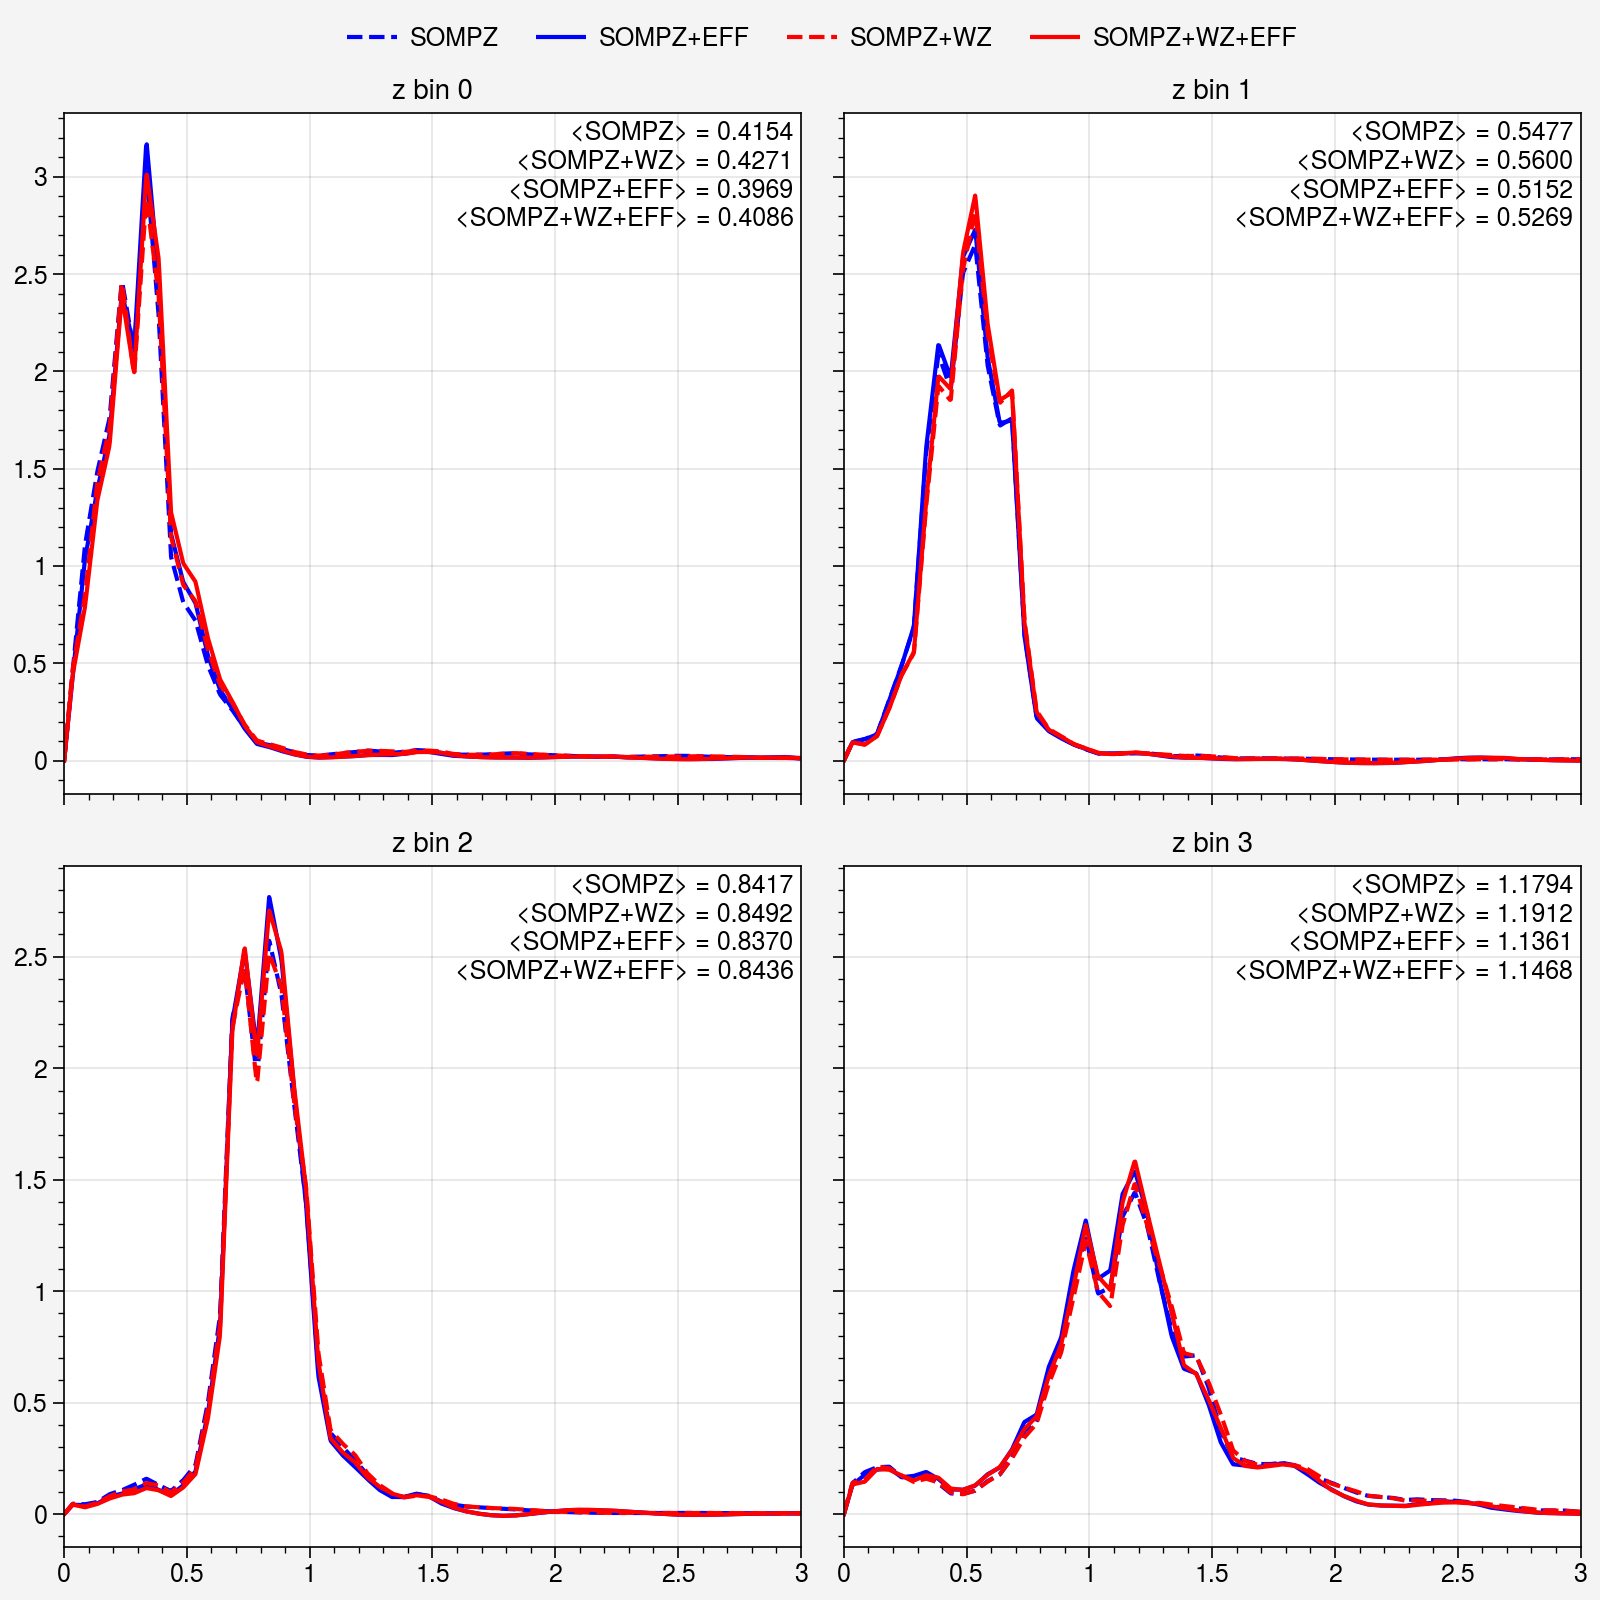

In [7]:
num_bins = 9
w = 0.1

fig, axs = uplt.subplots(nrows=2, ncols=2, figsize=(8, 8))

zbin = 0
for i in range(2):
    for j in range(2):
        ax = axs[i, j]

        nz_with_wz = np.mean(desnz_with_wz[:, zbin, :], axis=0)
        nz_with_wz = nz_with_wz / np.sum(nz_with_wz)

        nz = np.mean(desnz[:, zbin, :], axis=0)
        nz = nz / np.sum(nz)

        key = "statistical"
        nz_eff = np.mean(corr_nz[num_bins][w][key]["sompz"]["finalnzs"][:, zbin, :], axis=0)
        nz_eff = nz_eff / np.sum(nz_eff)

        nz_eff_with_wz = np.mean(corr_nz[num_bins][w][key]["sompz_wz"]["finalnzs"][:, zbin, :], axis=0)
        nz_eff_with_wz = nz_eff_with_wz / np.sum(nz_eff_with_wz)

        x = np.linspace(0, 3, 1000)

        _z, _nz = nz_binned_to_interp(nz)
        ax.plot(
            x,
            np.interp(x, _z, _nz),
            label="SOMPZ",
            color="blue",
            linestyle="dashed",
        )

        _z, _nz = nz_binned_to_interp(nz_eff)
        ax.plot(
            x,
            np.interp(x, _z, _nz),
            label="SOMPZ+EFF",
            color="blue",
        )

        _z, _nz = nz_binned_to_interp(nz_with_wz)
        ax.plot(
            x,
            np.interp(x, _z, _nz),
            label="SOMPZ+WZ",
            color="red",
            linestyle="dashed",
        )

        _z, _nz = nz_binned_to_interp(nz_eff_with_wz)
        ax.plot(
            x,
            np.interp(x, _z, _nz),
            label="SOMPZ+WZ+EFF",
            color="red",
        )

        ax.set_title("z bin %d" % zbin)

        msg = f"""\
<SOMPZ> = {compute_nz_binned_mean(nz):0.4f}
<SOMPZ+WZ> = {compute_nz_binned_mean(nz_with_wz):0.4f}
<SOMPZ+EFF> = {compute_nz_binned_mean(nz_eff):0.4f}
<SOMPZ+WZ+EFF> = {compute_nz_binned_mean(nz_eff_with_wz):0.4f}
        """
        ax.text(0.99, 0.99, msg, ha="right", va="top", transform=ax.transAxes)

        zbin += 1

        if i == 0 and j == 0:
            fig.legend(loc="t", frameon=False, ncols=4)


In [ ]:

all_mvals = np.concatenate([corr_nz[9][0.1][k]["sompz"]["mvals"] for k in keys])
all_dzvals = np.concatenate([corr_nz[9][0.1][k]["sompz"]["dzvals"] for k in keys])
all_finalnzs = np.concatenate([corr_nz[9][0.1][k]["sompz"]["finalnzs"] for k in keys])

m_mn = [np.mean(all_mvals[:, i]) for i in range(4)]
m_sd = [np.std(all_mvals[:, i]) for i in range(4)]

dz_mn = [np.mean(all_dzvals[:, i]) for i in range(4)]
dz_sd = [np.std(all_dzvals[:, i]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -6.5 +/- 22.8    | -0.018 +/- 0.008 |
| 1   |  +1.3 +/- 27.5    | -0.037 +/- 0.013 |
| 2   | +20.3 +/- 21.6    | -0.005 +/- 0.007 |
| 3   |  -5.6 +/- 39.6    | -0.042 +/- 0.012 |
|--------------------------------------------|


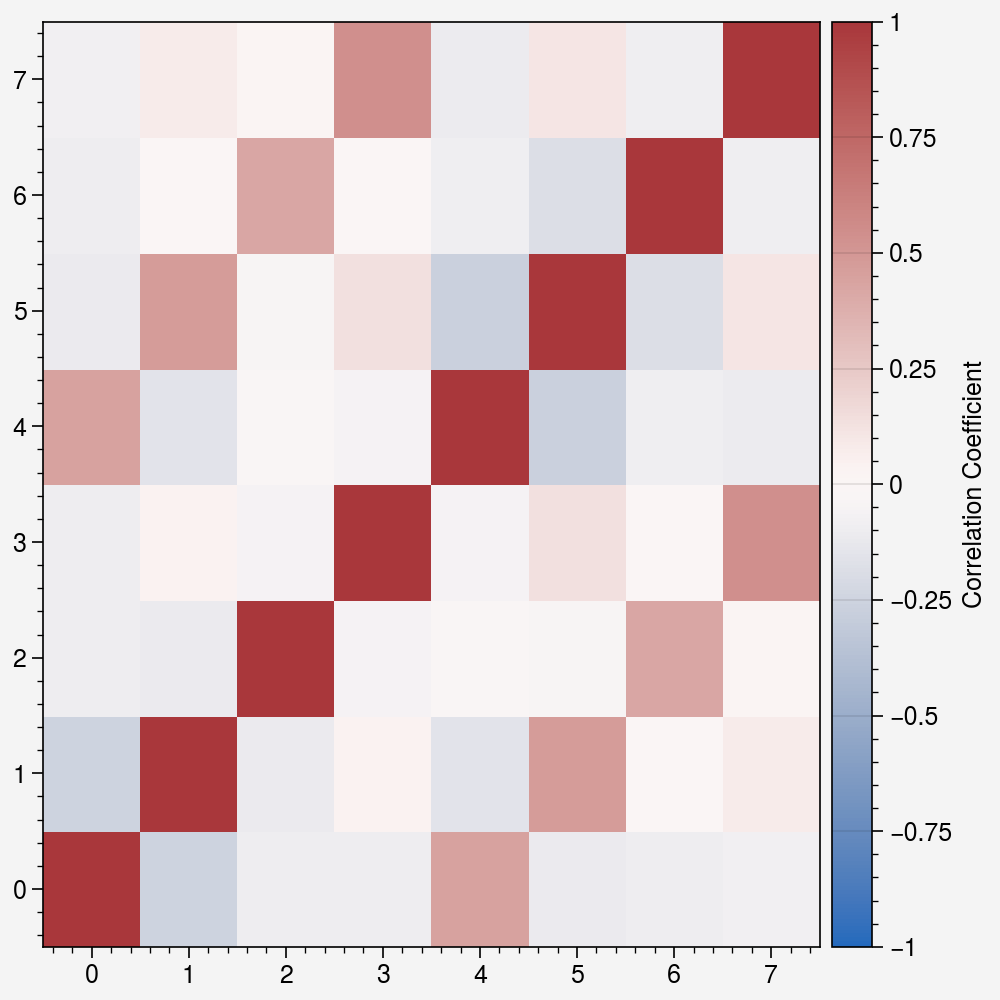

In [10]:
mdz = np.concatenate([mvals[key], dzvals[key]], axis=1)

corr = np.corrcoef(mdz.T)

fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)

## Look At Results from Boyan

In [12]:
data = np.load("des_y6_wz_blending_corrected_info.npz")

In [13]:
total = np.concatenate([data["m"], data["u"]], axis=1)

In [14]:
cov = np.cov(total.T)
corr = np.corrcoef(total.T)
mn = np.mean(total, axis=0)

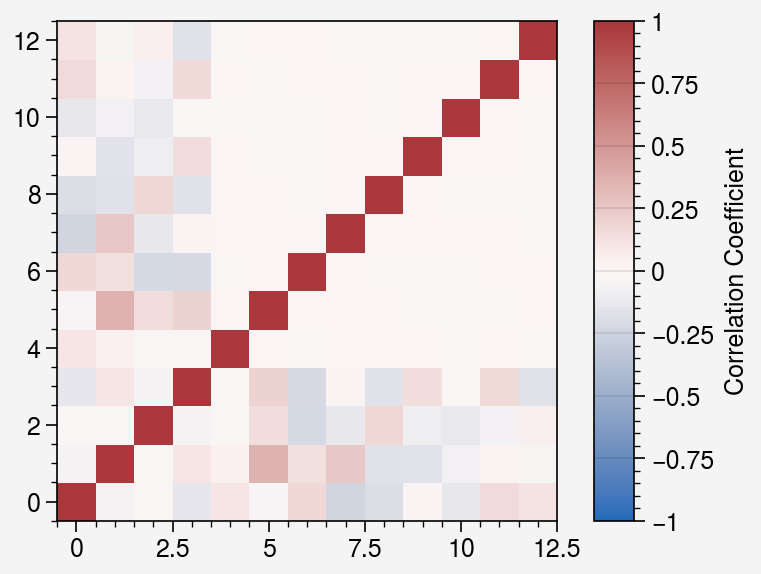

In [15]:
fig, axs = uplt.subplots()

m = axs.pcolormesh(corr, vmin=-1, vmax=1, cmap="vlag", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)

In [16]:
import scipy.stats

total_gauss = scipy.stats.multivariate_normal(mean=mn, cov=cov).rvs(size=total.shape[0])

Bad value in file PosixPath('/Users/beckermr/mambaforge/envs/des-y6/lib/python3.11/site-packages/arviz/plots/styles/arviz-grayscale.mplstyle'), line 33 ('image.cmap: cet_gray #  perceptually uniform gray scale from colorcet (linear_grey_10_95_c0)'): 'image.cmap is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'


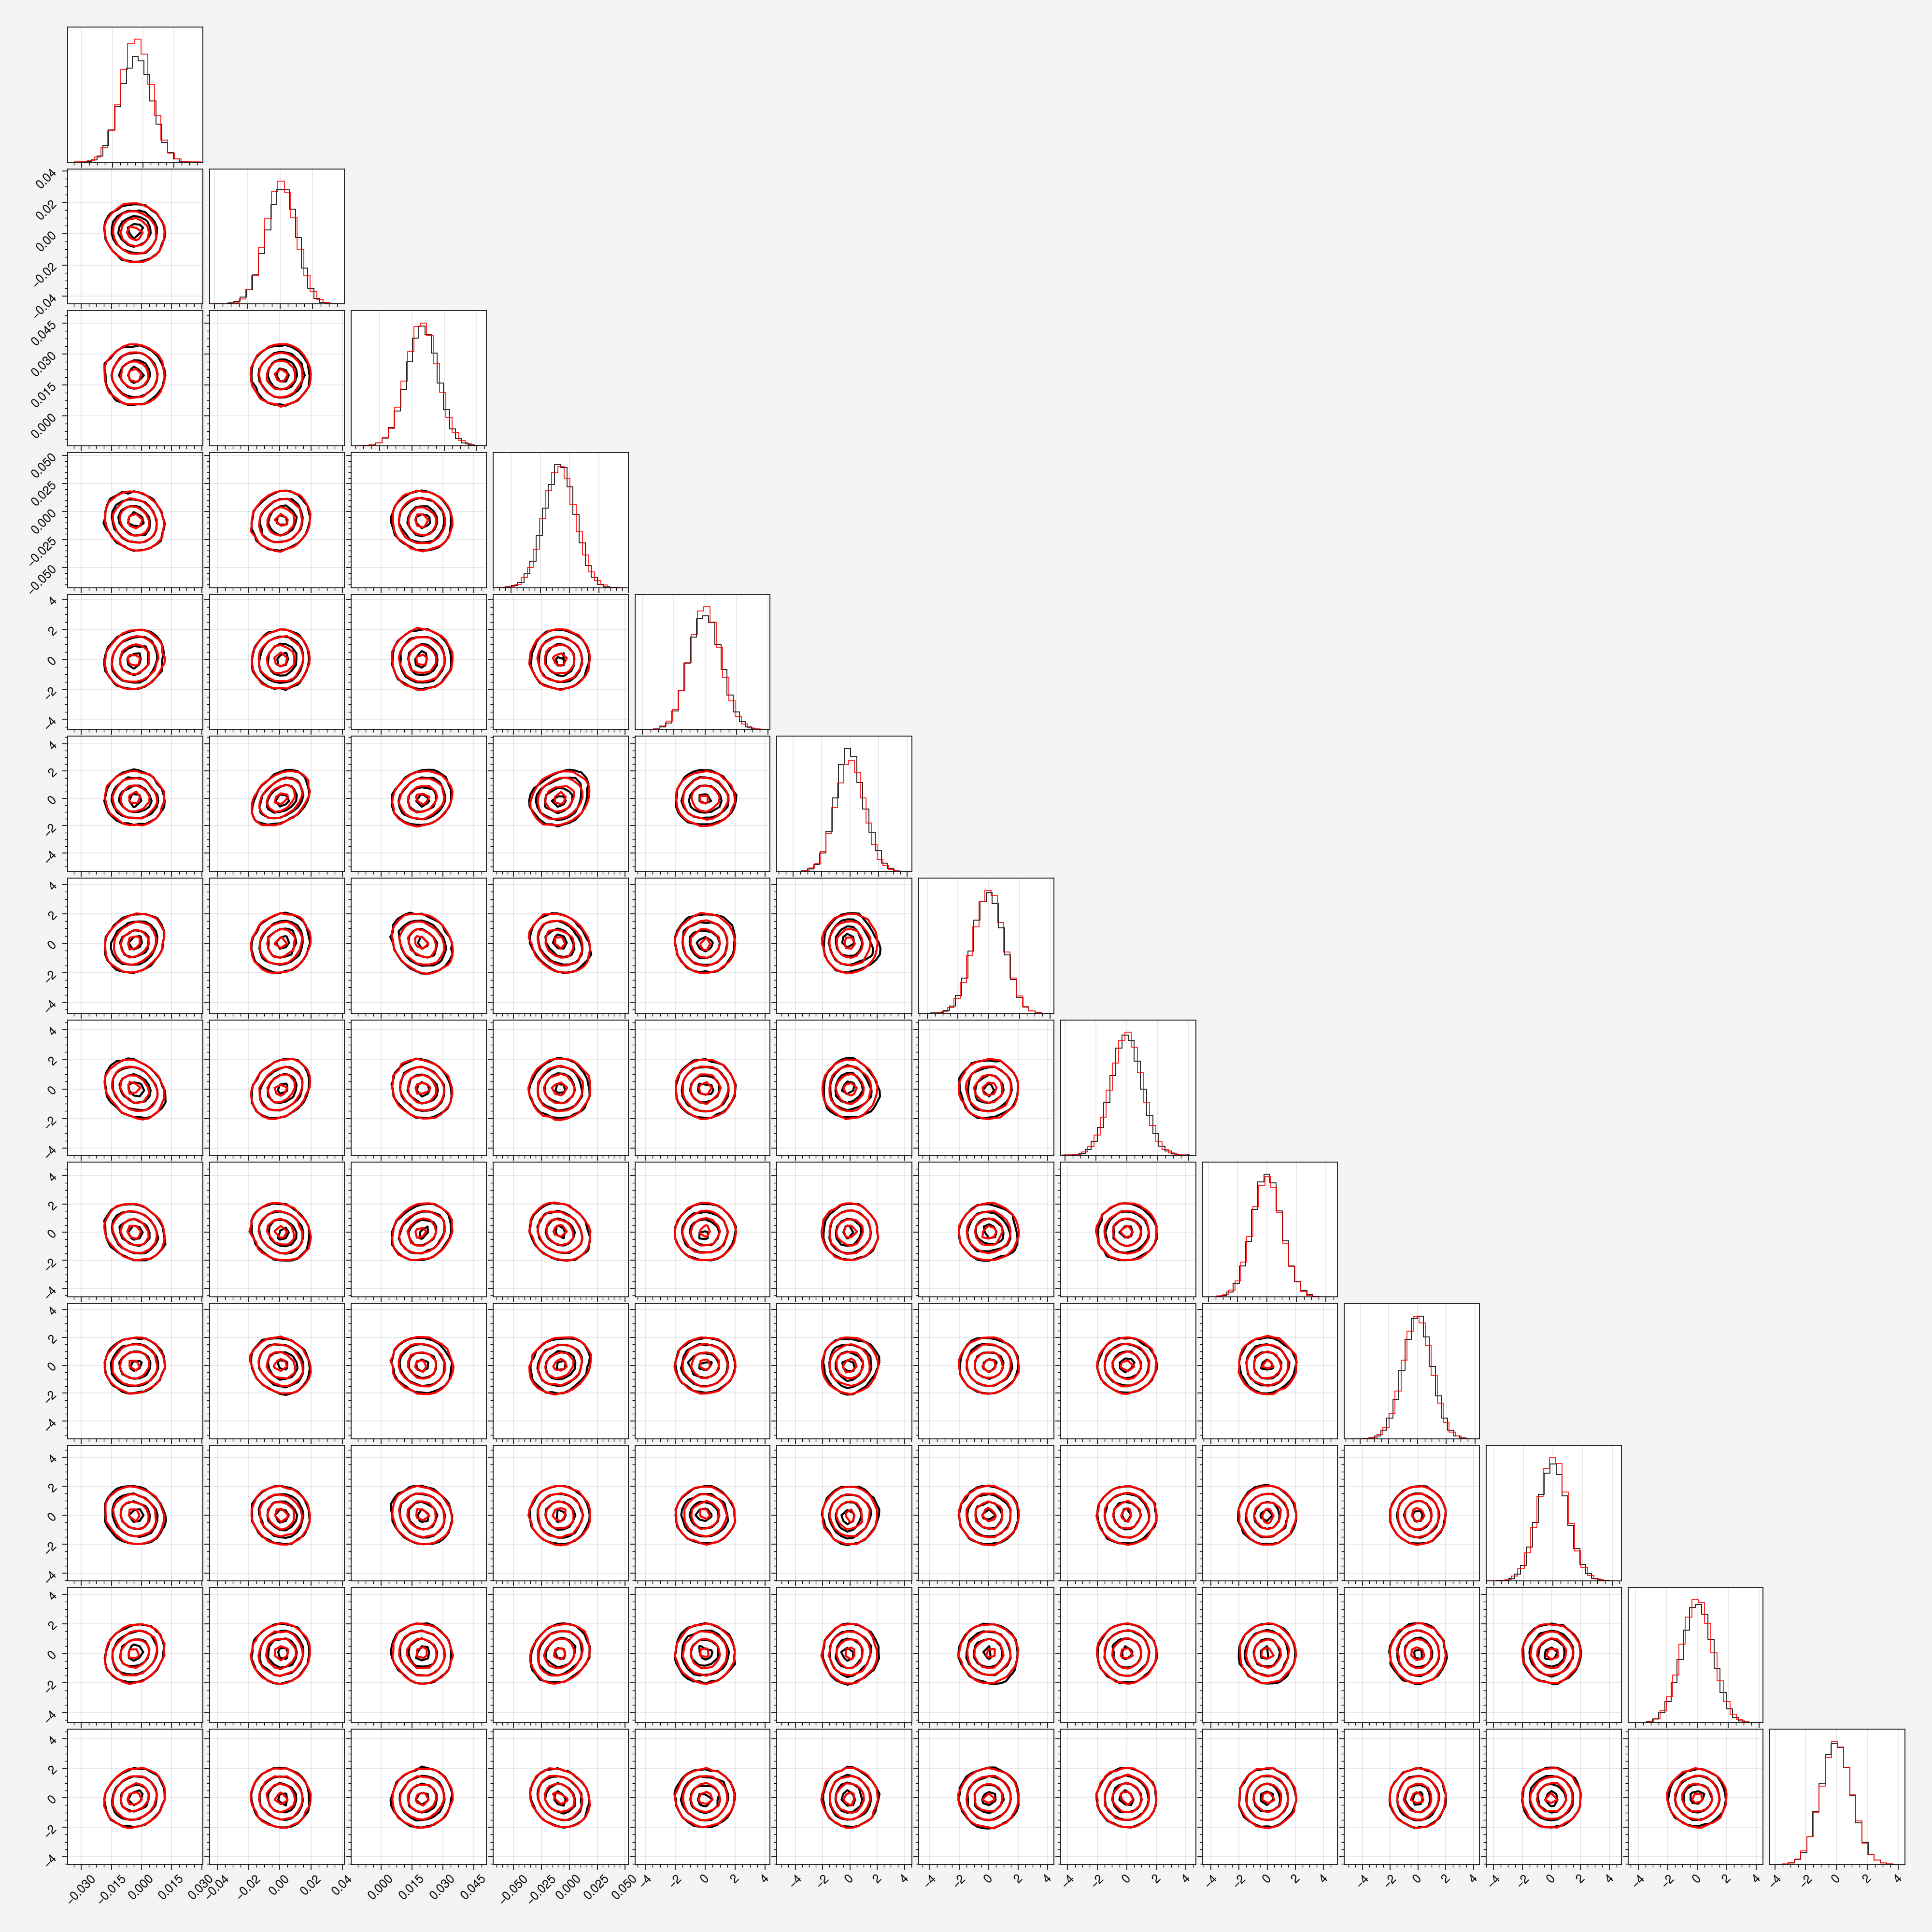

In [17]:
import corner
from matplotlib import pyplot as plt

kwargs = {"alpha": 0.25}

fig, axs = plt.subplots(nrows=13, ncols=13, figsize=(20, 20))
corner.corner(total, fig=fig, plot_datapoints=False, plot_density=False)
corner.corner(total_gauss, fig=fig, color="red", contourf_kwargs=kwargs, data_kwargs=kwargs, plot_datapoints=False, plot_density=False);


In [18]:
print(mn)

[-3.39285812e-03  6.58913864e-04  1.98208656e-02 -8.43969210e-03
  8.87534203e-06 -2.66218755e-05 -4.19153871e-06  3.51338264e-05
 -1.87451399e-05  7.05990843e-05  5.52872519e-05  7.96437786e-05
 -1.23351641e-05]


In [19]:
print(cov)

[[ 5.51289300e-05 -4.00222441e-06 -1.36542151e-08 -1.35130326e-05
   8.43404262e-04 -2.37993443e-04  1.33201018e-03 -1.76074027e-03
  -1.35676335e-03  1.84583109e-04 -9.76773332e-04  1.16861698e-03
   9.17926534e-04]
 [-4.00222441e-06  8.53515184e-05 -1.32350236e-07  1.35973833e-05
   4.58223979e-04  3.32421654e-03  1.29103683e-03  2.37760663e-03
  -1.47833824e-03 -1.42808701e-03 -6.76240999e-04  3.50383198e-04
  -4.07357132e-04]
 [-1.36542151e-08 -1.32350236e-07  5.25698679e-05 -5.17441193e-06
  -3.10123256e-05  1.08826207e-03 -1.54110114e-03 -9.42388041e-04
   1.35121573e-03 -7.35209745e-04 -8.69275865e-04 -5.01118066e-04
   4.53267338e-04]
 [-1.35130326e-05  1.35973833e-05 -5.17441193e-06  1.73708492e-04
  -5.67161590e-05  2.63719169e-03 -2.75719226e-03  3.10473603e-04
  -2.13647834e-03  2.03747562e-03 -2.02226268e-04  2.18660375e-03
  -2.10905098e-03]
 [ 8.43404262e-04  4.58223979e-04 -3.10123256e-05 -5.67161590e-05
   1.00002775e+00  2.38039358e-06 -1.58119036e-06  8.73045974e-06
